In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from scipy.optimize import root
import h5py
import os
import itertools
import gvar as gv

n_boot = 200
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from pytools import *
from formattools import *
from plottools import *
style = styles['notebook']

# Plot data

In [2]:
# utility functions for plotting
h = lambda p : np.sum(p ** 4) / (square(p) ** 2)
cols = ['k', 'tab:brown', 'b', 'g', 'y', 'tab:orange', 'r', 'm']
cuts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
patches = [mpatches.Patch(color = cols[ii], label = '$h(p) < ' + str(cuts[ii]) + '$') for ii in range(len(cols))]
def color_fn(hp):
    for ii in range(len(cols)):
        if hp < cuts[ii]:
            return cols[ii]
    return cols[-1]
def plot_h4_breaking(apsq_list, Zmu, Zsigma, ylabel, color_list, title = None, plt_geom = (1, 1), fsize = (10, 6), \
                     leg_loc = (1., 1.), plot_mu = False):
    with sns.plotting_context('talk'):
        if plt_geom == (1, 1):
            plt.figure(figsize = (10, 6))
            for ii in range(len(apsq_list)):
                plt.errorbar(apsq_list[ii], Zmu[ii], Zsigma[ii], fmt = '.', c = color_list[ii])
            if plot_mu:
                plt.xlabel('$\mu^2$ ($\\mathrm{GeV}^2$)')
            else:
                plt.xlabel('$(ap)^2$')
            #plt.xlim((0, 7))
            plt.ylabel(ylabel)
            if title:
                plt.title(title)
            plt.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.show()
        else:
            fig, ax = plt.subplots(plt_geom[0], plt_geom[1], figsize = fsize)
            for i in range(plt_geom[0]):
                for j in range(plt_geom[1]):
                    tidx = j * plt_geom[0] + i
                    if tidx >= Zmu.shape[0]:
                        continue
                    for pidx in range(len(apsq_list_sub)):
                        ax[i, j].errorbar(apsq_list_sub[pidx], Zmu[tidx, pidx], Zsigma[tidx, pidx], fmt = '.', \
                                          c = color_list[pidx])
                    if plot_mu:
                        ax[i, j].set_xlabel('$\mu^2$ ($\\mathrm{GeV}^2$)')
                    else:
                        ax[i, j].set_xlabel('$(ap)^2$')
                    ax[i, j].set_ylabel(ylabel)
                    #ax[i, j].set_xlim((0, 7))
                    if title:
                        ax[i, j].set_title(title + ', comp ' + str(tidx) + ' in RI/MOM')
            fig.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.tight_layout()
            plt.show()

### Ensemble cl21_12_24_b6p1_m0p2800m0p2450_114141 ($12^3$ heavy)

Note that I originally ran this ensemble in job 106539, although I inverted the propagators there at the wrong light quark mass. Job 114141 has corrected this and inverted everything at the correct light quark mass (although there's really not much of a difference)

In [3]:
l12, t12 = 12, 24
# file_12_heavy = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_106539.h5'
file_12_heavy1 = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_114141.h5'

Lat12 = Lattice(l12, t12)
f12_heavy1 = h5py.File(file_12_heavy1, 'r')
print('Ran on ' + str(f12_heavy1['cfgnum'][()]) + ' cfgs.')
k_list12 = f12_heavy1['momenta'][()]
Zq_12_heavy1 = np.real(f12_heavy1['Zq'][()])
Zqq_mix_12_heavy1 = f12_heavy1['Zqq_mix'][()]
f12_heavy1.close()

Ran on 220 cfgs.


In [4]:
# Geometry-specific input for 12^3 x 24
kidx = 0
k_subset_idxs12 = []
for k in k_list12:
    # if True:
    # if k[0] < 5 and k[1] < 5 and k[2] < 5 and k[3] < 5:
    if k[0] < Lat12.L // 2 and k[1] < Lat12.L // 2 and k[2] < Lat12.L // 2 and k[3] < Lat12.L // 2:
        k_subset_idxs12.append(kidx)
    kidx += 1
k_subset_idxs12 = np.array(k_subset_idxs12)

# only use k if it's less than L / 2 in each component
# k_list = k_list[k_subset_idxs]
p_list12 = np.array([Lat12.to_linear_momentum(k) for k in k_list12])
plat_list12 = np.array([Lat12.to_lattice_momentum(k) for k in k_list12])
apsq_list12 = np.real(np.array([square(p) for p in p_list12]))

k_list_sub12 = k_list12[k_subset_idxs12]
p_list_sub12 = p_list12[k_subset_idxs12]
plat_list_sub12 = plat_list12[k_subset_idxs12]
apsq_list_sub12 = apsq_list12[k_subset_idxs12]

hp_list12 = np.real(np.array([h(p) for p in p_list12]))
hp_list_sub12 = hp_list12[k_subset_idxs12]
color_list12 = [color_fn(hp) for hp in hp_list12]
color_list_sub12 = [color_fn(hp) for hp in hp_list_sub12]

In [5]:
# ensemble-specific input
Zq_12_heavy_mu1 = np.mean(Zq_12_heavy1, axis = 1)
Zq_12_heavy_sigma1 = np.std(Zq_12_heavy1, axis = 1, ddof = 1)
Zqq_mix_12_heavy_mu1 = np.mean(np.real(Zqq_mix_12_heavy1), axis = 2)
Zqq_mix_12_heavy_sigma1 = np.std(np.real(Zqq_mix_12_heavy1), axis = 2, ddof = 1)

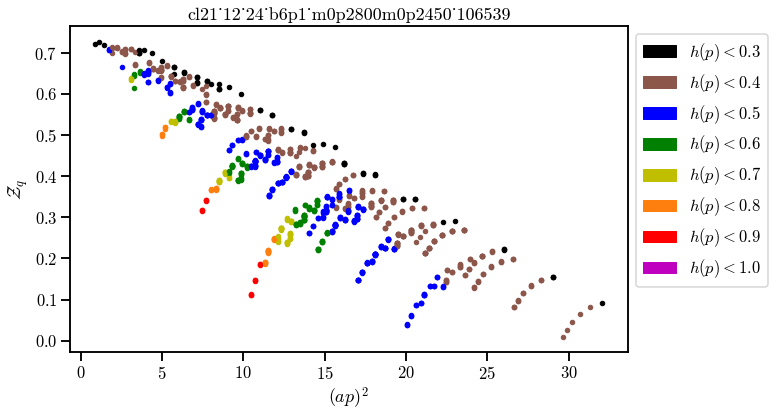

In [6]:
plot_h4_breaking(apsq_list12, Zq_12_heavy_mu1, Zq_12_heavy_sigma1, '$\mathcal{Z}_q$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_106539')

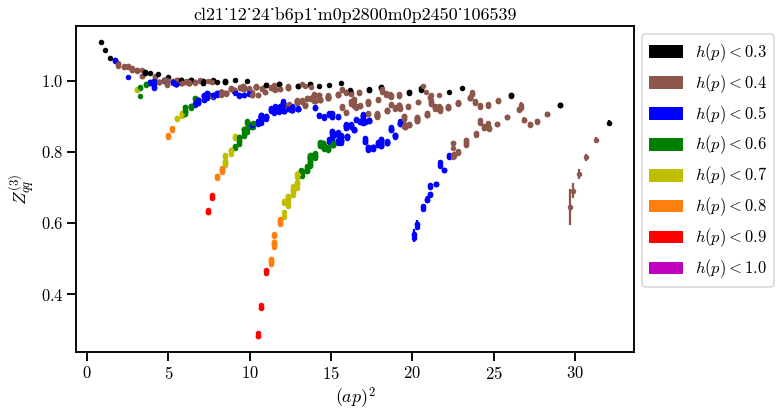

In [7]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_heavy_mu1[0], Zqq_mix_12_heavy_sigma1[0], '$Z_{qq}^{(3)}$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_106539')

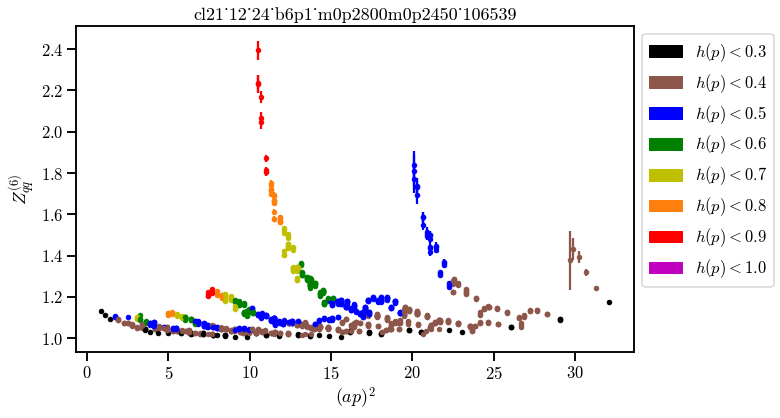

In [8]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_heavy_mu1[1], Zqq_mix_12_heavy_sigma1[1], '$Z_{qq}^{(6)}$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_106539')

$a = 0.1167\;\mathrm{fm}$

Plot data for job 117649, which has ~2000 configurations on the same ensemble

In [9]:
l12, t12 = 12, 24
# file_12_heavy = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_106539.h5'
file_12_heavy = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_117649.h5'

Lat12 = Lattice(l12, t12)
f12_heavy = h5py.File(file_12_heavy, 'r')
print('Ran on ' + str(f12_heavy['cfgnum'][()]) + ' cfgs.')
k_list12 = f12_heavy['momenta'][()]
Zq_12_heavy = np.real(f12_heavy['Zq'][()])
Zqq_mix_12_heavy = f12_heavy['Zqq_mix'][()]
f12_heavy.close()

Ran on 2212 cfgs.


In [10]:
# ensemble-specific input
Zq_12_heavy_mu = np.mean(Zq_12_heavy, axis = 1)
Zq_12_heavy_sigma = np.std(Zq_12_heavy, axis = 1, ddof = 1)
Zqq_mix_12_heavy_mu = np.mean(np.real(Zqq_mix_12_heavy), axis = 2)
Zqq_mix_12_heavy_sigma = np.std(np.real(Zqq_mix_12_heavy), axis = 2, ddof = 1)

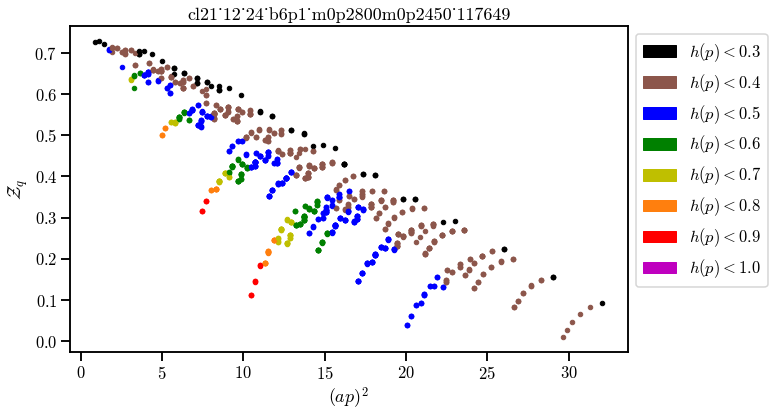

In [11]:
plot_h4_breaking(apsq_list12, Zq_12_heavy_mu, Zq_12_heavy_sigma, '$\mathcal{Z}_q$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_117649')

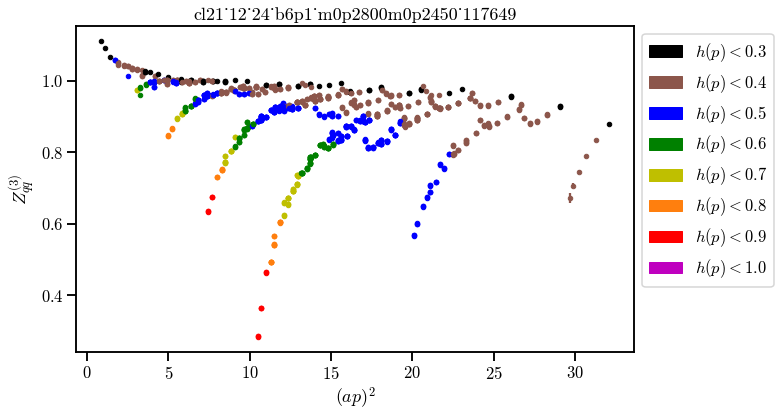

In [12]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_heavy_mu[0], Zqq_mix_12_heavy_sigma[0], '$Z_{qq}^{(3)}$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_117649')

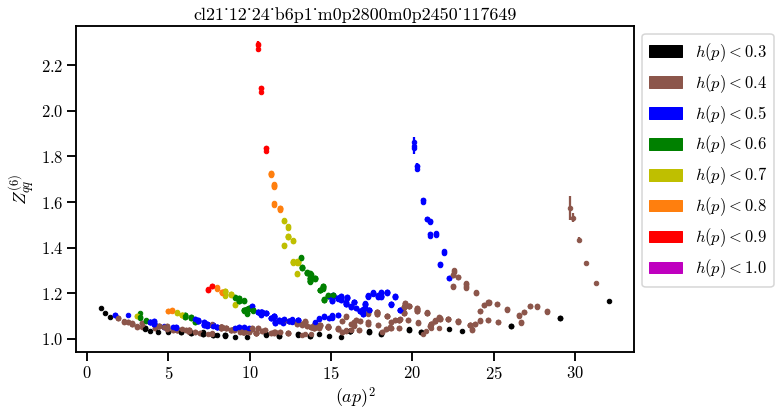

In [13]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_heavy_mu[1], Zqq_mix_12_heavy_sigma[1], '$Z_{qq}^{(6)}$', color_list12, \
                 title = 'cl21_12_24_b6p1_m0p2800m0p2450_117649')

### Ensemble cl21_12_24_b6p3_m0p2416m0p2050-b_113030

In [14]:
file12_light = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_113030.h5'

f12_light = h5py.File(file12_light, 'r')
print('Ran on ' + str(f12_light['cfgnum'][()]) + ' cfgs.')
Zq_12_light = np.real(f12_light['Zq'][()])
Zqq_mix_12_light = f12_light['Zqq_mix'][()]
f12_light.close()

Ran on 64 cfgs.


In [15]:
# ensemble-specific input
Zq_12_light_mu = np.mean(Zq_12_light, axis = 1)
Zq_12_light_sigma = np.std(Zq_12_light, axis = 1, ddof = 1)
Zqq_mix_12_light_mu = np.mean(np.real(Zqq_mix_12_light), axis = 2)
Zqq_mix_12_light_sigma = np.std(np.real(Zqq_mix_12_light), axis = 2, ddof = 1)

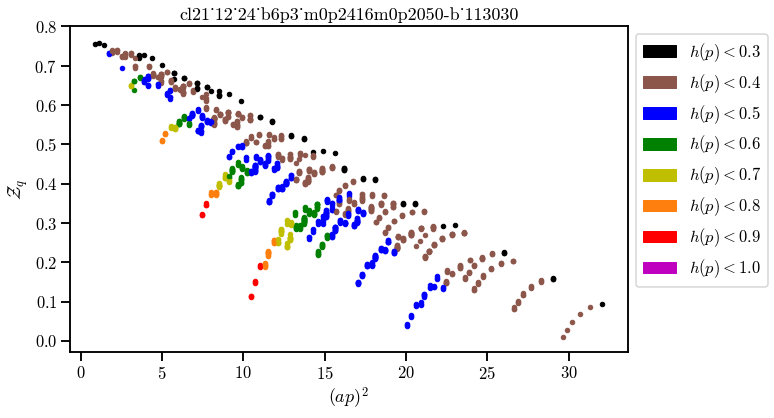

In [16]:
plot_h4_breaking(apsq_list12, Zq_12_light_mu, Zq_12_light_sigma, '$\mathcal{Z}_q$', color_list12, \
                 title = 'cl21_12_24_b6p3_m0p2416m0p2050-b_113030')

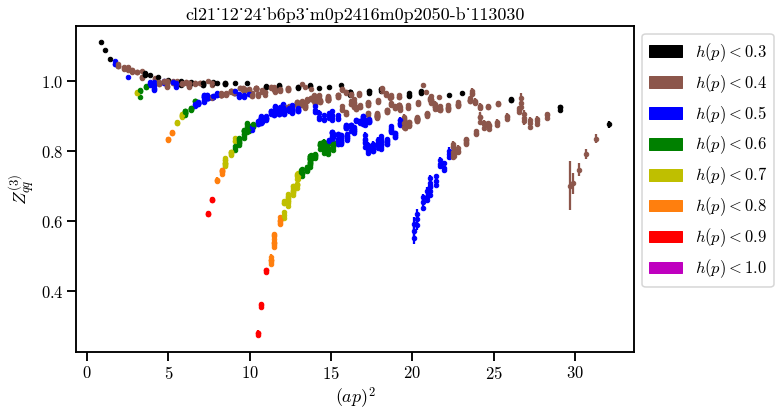

In [17]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_light_mu[0], Zqq_mix_12_light_sigma[0], '$Z_{qq}^{(3)}$', color_list12, \
                 title = 'cl21_12_24_b6p3_m0p2416m0p2050-b_113030')

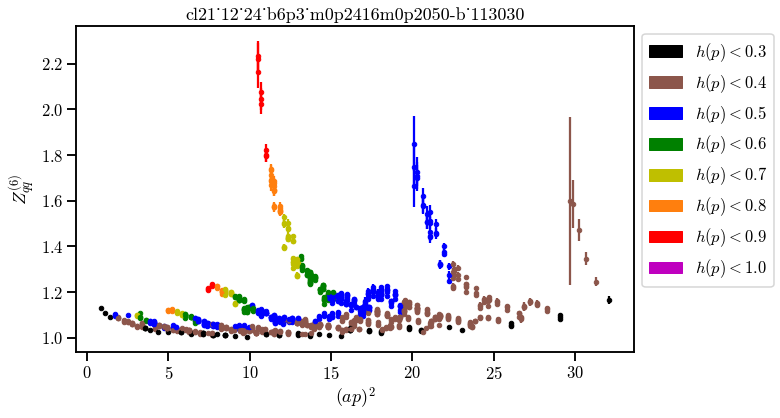

In [18]:
plot_h4_breaking(apsq_list12, Zqq_mix_12_light_mu[1], Zqq_mix_12_light_sigma[1], '$Z_{qq}^{(6)}$', color_list12, \
                 title = 'cl21_12_24_b6p3_m0p2416m0p2050-b_113030')

### Ensemble cl21_16_16_b6p3_m0p2416m0p2050-a_113356

In [19]:
l16, t16 = 16, 16
file_16 = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_113356.h5'

Lat16 = Lattice(l16, t16)
f16 = h5py.File(file_16, 'r')
print('Ran on ' + str(f16['cfgnum'][()]) + ' cfgs.')
k_list16 = f16['momenta'][()]
Zq_16 = np.real(f16['Zq'][()])
Zqq_mix_16 = f16['Zqq_mix'][()]
f16.close()

Ran on 199 cfgs.


In [20]:
# Geometry-specific input for 12^3 x 24
kidx = 0
k_subset_idxs16 = []
for k in k_list16:
    # if True:
    # if k[0] < 5 and k[1] < 5 and k[2] < 5 and k[3] < 5:
    if k[0] < Lat16.L // 2 and k[1] < Lat16.L // 2 and k[2] < Lat16.L // 2 and k[3] < Lat16.L // 2:
        k_subset_idxs16.append(kidx)
    kidx += 1
k_subset_idxs16 = np.array(k_subset_idxs16)

# only use k if it's less than L / 2 in each component
# k_list = k_list[k_subset_idxs]
p_list16 = np.array([Lat16.to_linear_momentum(k) for k in k_list16])
plat_list16 = np.array([Lat16.to_lattice_momentum(k) for k in k_list16])
apsq_list16 = np.real(np.array([square(p) for p in p_list16]))

k_list_sub16 = k_list16[k_subset_idxs16]
p_list_sub16 = p_list16[k_subset_idxs16]
plat_list_sub16 = plat_list16[k_subset_idxs16]
apsq_list_sub16 = apsq_list16[k_subset_idxs16]

hp_list16 = np.real(np.array([h(p) for p in p_list16]))
hp_list_sub16 = hp_list16[k_subset_idxs16]
color_list16 = [color_fn(hp) for hp in hp_list16]
color_list_sub16 = [color_fn(hp) for hp in hp_list_sub16]

In [21]:
# ensemble-specific input
Zq_16_mu = np.mean(Zq_16, axis = 1)
Zq_16_sigma = np.std(Zq_16, axis = 1, ddof = 1)
Zqq_mix_16_mu = np.mean(np.real(Zqq_mix_16), axis = 2)
Zqq_mix_16_sigma = np.std(np.real(Zqq_mix_16), axis = 2, ddof = 1)

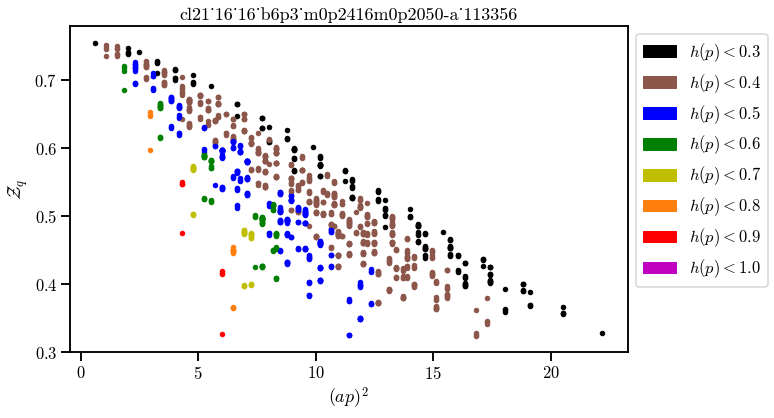

In [22]:
plot_h4_breaking(apsq_list16, Zq_16_mu, Zq_16_sigma, '$\mathcal{Z}_q$', color_list16, \
                 title = 'cl21_16_16_b6p3_m0p2416m0p2050-a_113356')

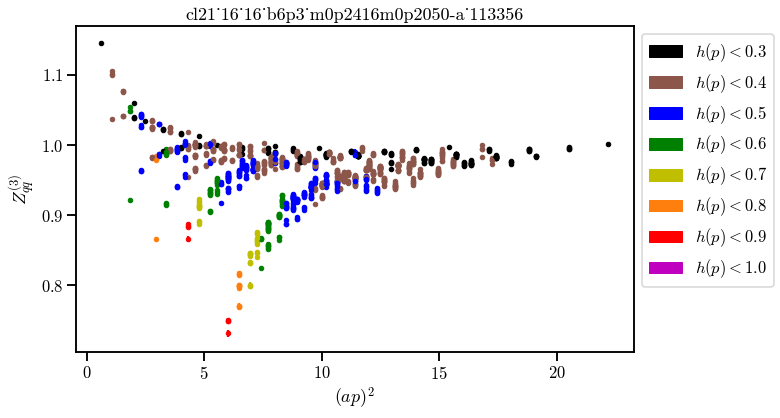

In [23]:
plot_h4_breaking(apsq_list16, Zqq_mix_16_mu[0], Zqq_mix_16_sigma[0], '$Z_{qq}^{(3)}$', color_list16, \
                 title = 'cl21_16_16_b6p3_m0p2416m0p2050-a_113356')

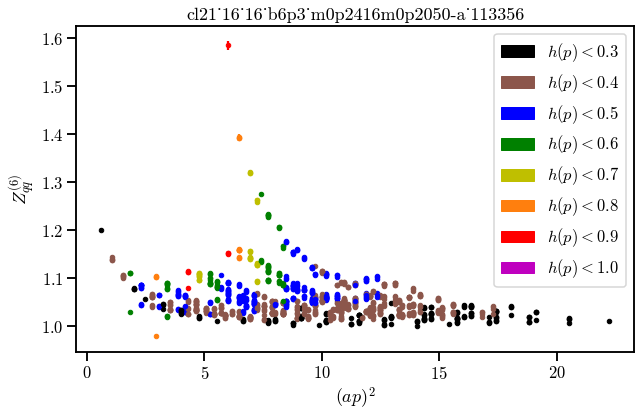

In [24]:
plot_h4_breaking(apsq_list16, Zqq_mix_16_mu[1], Zqq_mix_16_sigma[1], '$Z_{qq}^{(6)}$', color_list16, \
                 title = 'cl21_16_16_b6p3_m0p2416m0p2050-a_113356')

### Ensemble cl21_48_96_b6p3_m0p2416_m0p2050_115282

In [25]:
l48, t48 = 48, 96
file_48 = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_115282.h5'
a_48 = 0.091

Lat48 = Lattice(l48, t48)
f48 = h5py.File(file_48, 'r')
print('Ran on ' + str(f48['cfgnum'][()]) + ' cfgs.')
k_list48 = f48['momenta'][()]
mu_list48 = np.array([get_energy_scale(k, a_48, Lat48) for k in k_list48])
Zq_48 = np.real(f48['Zq'][()])
Zqq_mix_48 = f48['Zqq_mix'][()]
f48.close()

Ran on 24 cfgs.


In [26]:
# Geometry-specific input for 48^3 x 96
kidx = 0
k_subset_idxs48 = []
for k in k_list48:
    # if True:
    # if k[0] < 5 and k[1] < 5 and k[2] < 5 and k[3] < 5:
    if k[0] < Lat48.L // 2 and k[1] < Lat48.L // 2 and k[2] < Lat48.L // 2 and k[3] < Lat48.L // 2:
        k_subset_idxs48.append(kidx)
    kidx += 1
k_subset_idxs48 = np.array(k_subset_idxs48)

# only use k if it's less than L / 2 in each component
# k_list = k_list[k_subset_idxs]
p_list48 = np.array([Lat48.to_linear_momentum(k) for k in k_list48])
plat_list48 = np.array([Lat48.to_lattice_momentum(k) for k in k_list48])
apsq_list48 = np.real(np.array([square(p) for p in p_list48]))

k_list_sub48 = k_list48[k_subset_idxs48]
p_list_sub48 = p_list48[k_subset_idxs48]
plat_list_sub48 = plat_list48[k_subset_idxs48]
apsq_list_sub48 = apsq_list48[k_subset_idxs48]

hp_list48 = np.real(np.array([h(p) for p in p_list48]))
hp_list_sub48 = hp_list48[k_subset_idxs48]
color_list48 = [color_fn(hp) for hp in hp_list48]
color_list_sub48 = [color_fn(hp) for hp in hp_list_sub48]

In [27]:
# ensemble-specific input
Zq_48_mu = np.mean(Zq_48, axis = 1)
Zq_48_sigma = np.std(Zq_48, axis = 1, ddof = 1)
Zqq_mix_48_mu = np.mean(np.real(Zqq_mix_48), axis = 2)
Zqq_mix_48_sigma = np.std(np.real(Zqq_mix_48), axis = 2, ddof = 1)

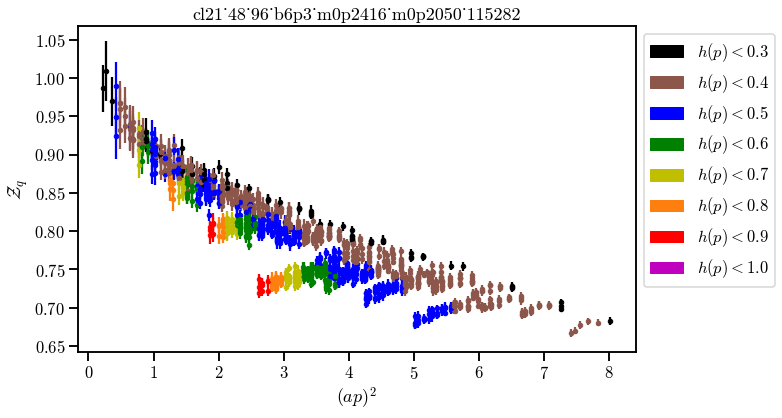

In [28]:
plot_h4_breaking(apsq_list48, Zq_48_mu, Zq_48_sigma, '$\mathcal{Z}_q$', color_list48, \
                 title = 'cl21_48_96_b6p3_m0p2416_m0p2050_115282')

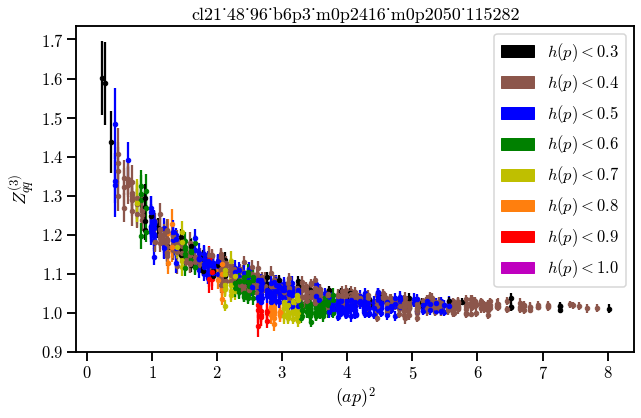

In [29]:
plot_h4_breaking(apsq_list48, Zqq_mix_48_mu[0], Zqq_mix_48_sigma[0], '$Z_{qq}^{(3)}$', color_list48, \
                 title = 'cl21_48_96_b6p3_m0p2416_m0p2050_115282')

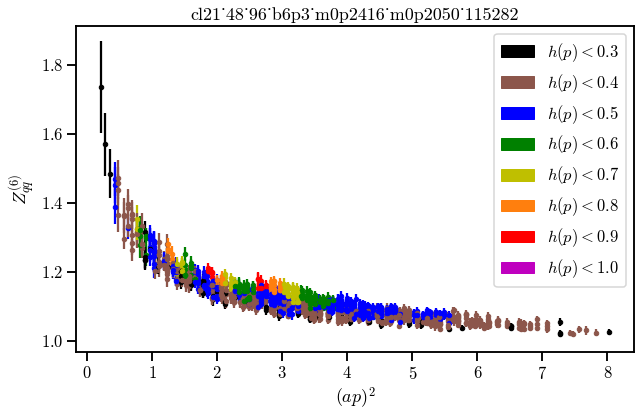

In [30]:
plot_h4_breaking(apsq_list48, Zqq_mix_48_mu[1], Zqq_mix_48_sigma[1], '$Z_{qq}^{(6)}$', color_list48, \
                 title = 'cl21_48_96_b6p3_m0p2416_m0p2050_115282')

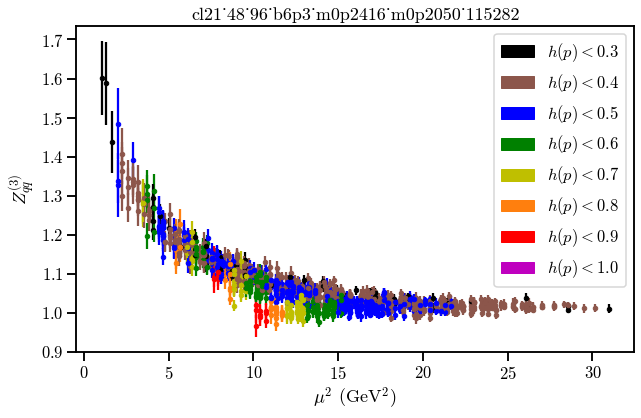

In [31]:
plot_h4_breaking(mu_list48**2, Zqq_mix_48_mu[0], Zqq_mix_48_sigma[0], '$Z_{qq}^{(3)}$', color_list48, \
                 title = 'cl21_48_96_b6p3_m0p2416_m0p2050_115282', plot_mu = True)

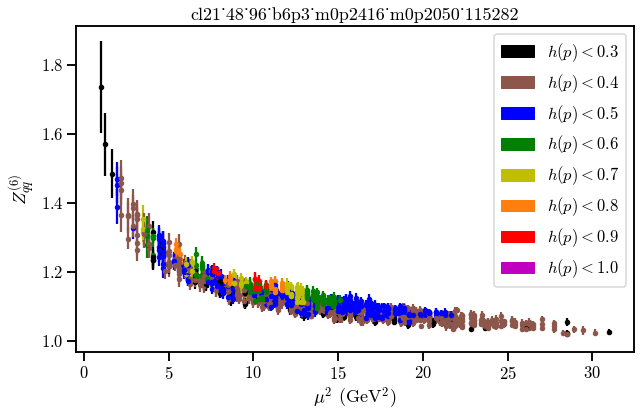

In [32]:
plot_h4_breaking(mu_list48**2, Zqq_mix_48_mu[1], Zqq_mix_48_sigma[1], '$Z_{qq}^{(6)}$', color_list48, \
                 title = 'cl21_48_96_b6p3_m0p2416_m0p2050_115282', plot_mu = True)

## Compare (rough) results on 12^3 heavy, 12^3 light, 16^4

In [33]:
Zqq_12_light = gv.gvar(0.999709, 0.013079)
Zqq_12_heavy = gv.gvar(0.98212, 0.021432)    # extra error is all from the fit
Zqq_16 = gv.gvar(0.984171, 0.0114678)
plot_means = [Zqq_12_light.mean, Zqq_12_heavy.mean, Zqq_16.mean]
plot_stds = [Zqq_12_light.sdev, Zqq_12_heavy.sdev, Zqq_16.sdev]

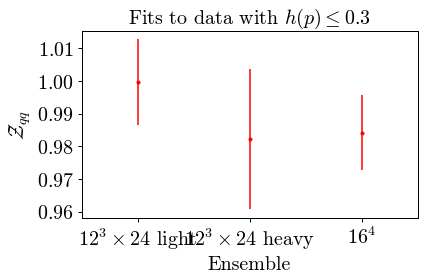

In [34]:
asp_ratio = 4/3
fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
plt.figure()
plt.errorbar([0, 1, 2], plot_means, yerr = plot_stds, fmt = '.', c = 'r')
ax = plt.gca()
ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['$12^3\\times 24$ light', '$12^3\\times 24$ heavy', '$16^4$'])
for spine in spinedirs:
    ax.spines[spine].set_linewidth(style['axeswidth'])
plt.xticks(fontsize = style['fontsize'])
plt.yticks(fontsize = style['fontsize'])
plt.xlabel('Ensemble', fontsize = style['fontsize'])
plt.ylabel('$\mathcal{Z}_{qq}$', fontsize = style['fontsize'])
plt.xlim((-0.5, 2.5))
plt.title('Fits to data with $h(p)\leq 0.3$', fontsize = style['fontsize'])
plt.tight_layout()
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/rough_comparison_6_19.pdf', bbox_inches='tight')
plt.show()

## Compare error on 100 configurations between 12^3 x 24 and 16^4

In [35]:
file12_light_30 = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_113030_30cfgs.h5'

f12_light_30 = h5py.File(file12_light_30, 'r')
print('Ran on ' + str(f12_light_30['cfgnum'][()]) + ' cfgs.')
k_list12_30 = f12_light_30['momenta'][()]
Zq_12_light_30 = np.real(f12_light_30['Zq'][()])
Zqq_mix_12_light_30 = f12_light_30['Zqq_mix'][()]
f12_light_30.close()
n_boot_30 = 50

Zqq_mix_12_light_30_cv = np.mean(Zqq_mix_12_light_30, axis = 2)
Zqq_mix_12_light_30_std = np.std(Zqq_mix_12_light_30, axis = 2, ddof = 1)
p_list12_30 = np.array([Lat12.to_linear_momentum(k) for k in k_list12_30])
ap_list12_30 = np.real(np.array([square(p) for p in p_list12_30]))

Ran on 30 cfgs.


In [36]:
file16_30 = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_113356_30cfgs.h5'

f16_30 = h5py.File(file16_30, 'r')
print('Ran on ' + str(f16_30['cfgnum'][()]) + ' cfgs.')
k_list16_30 = f16_30['momenta'][()]
Zq_16_30 = np.real(f16_30['Zq'][()])
Zqq_mix_16_30 = f16_30['Zqq_mix'][()]
f16_30.close()

Zqq_mix_16_30_cv = np.mean(Zqq_mix_16_30, axis = 2)
Zqq_mix_16_30_std = np.std(Zqq_mix_16_30, axis = 2, ddof = 1)
p_list16_30 = np.array([Lat16.to_linear_momentum(k) for k in k_list16_30])
ap_list16_30 = np.real(np.array([square(p) for p in p_list16_30]))

Ran on 30 cfgs.


In [37]:
ϵ = 1e-5
for ii in range(len(ap_list12_30)):
    for jj in range(len(ap_list16_30)):
        if np.abs(ap_list12_30[ii] - ap_list16_30[jj]) < ϵ:
            print(ii, jj)

40 26
40 62
40 74
40 78


In [38]:
vol12 = (12**3) * 24
vol16 = 16**4
sto_scale = np.sqrt(vol16 / vol12)
dat1_cvs = np.real([Zqq_mix_12_light_30_cv[0, 0], Zqq_mix_16_30_cv[0, 0]])
dat1_stds = np.real([Zqq_mix_12_light_30_std[0, 0], Zqq_mix_16_30_std[0, 0]])
dat1_stds_rescale = np.real([Zqq_mix_12_light_30_std[0, 0] * sto_scale, Zqq_mix_16_30_std[0, 0]])
dat2_cvs = np.real([Zqq_mix_12_light_30_cv[0, 40], Zqq_mix_16_30_cv[0, 26]])
dat2_stds = np.real([Zqq_mix_12_light_30_std[0, 40], Zqq_mix_16_30_std[0, 26]])
dat2_stds_rescale = np.real([Zqq_mix_12_light_30_std[0, 40] * sto_scale, Zqq_mix_16_30_std[0, 26]])
print('$\sqrt{V_{16} / V_{12}}$ = ' + str(sto_scale))
print('Error ratio σ_{12} / σ_{16} at fixed k = ' + str(dat1_stds[1] / dat1_stds[0]))
print('Error ratio σ_{12} / σ_{16} at fixed (ap)^2 = ' + str(dat2_stds[1] / dat2_stds[0]))

$\sqrt{V_{16} / V_{12}}$ = 1.2570787221094177
Error ratio σ_{12} / σ_{16} at fixed k = 1.2468956
Error ratio σ_{12} / σ_{16} at fixed (ap)^2 = 1.0407014


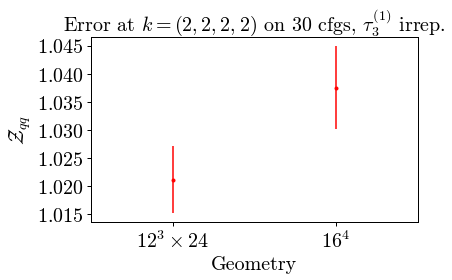

In [39]:
asp_ratio = 4/3
fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
plt.figure()
plt.errorbar([0, 1], dat1_cvs, dat1_stds, fmt = '.', c = 'r')
ax = plt.gca()
ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['$12^3\\times 24$', '$16^4$'])
for spine in spinedirs:
    ax.spines[spine].set_linewidth(style['axeswidth'])
plt.xticks(fontsize = style['fontsize'])
plt.yticks(fontsize = style['fontsize'])
plt.xlabel('Geometry', fontsize = style['fontsize'])
plt.ylabel('$\mathcal{Z}_{qq}$', fontsize = style['fontsize'])
plt.xlim((-0.5, 1.5))
plt.title('Error at $k = (2, 2, 2, 2)$ on 30 cfgs, $\\tau^{(1)}_3$ irrep.', fontsize = style['fontsize'])
plt.tight_layout()
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/error_scaling/fixed_k_data.pdf', bbox_inches='tight')
plt.show()

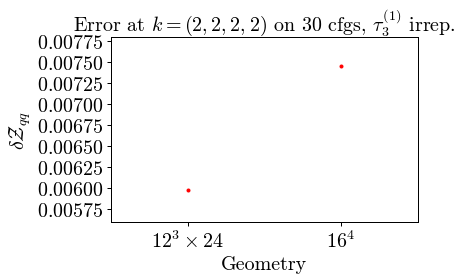

In [40]:
asp_ratio = 4/3
fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
plt.figure()
# plt.errorbar([0, 1], dat1_cvs, dat1_stds, fmt = '.')
plt.scatter([0, 1], dat1_stds, marker = '.', color = 'r')
ax = plt.gca()
ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['$12^3\\times 24$', '$16^4$'])
for spine in spinedirs:
    ax.spines[spine].set_linewidth(style['axeswidth'])
plt.xticks(fontsize = style['fontsize'])
plt.yticks(fontsize = style['fontsize'])
plt.xlabel('Geometry', fontsize = style['fontsize'])
plt.ylabel('$\delta\mathcal{Z}_{qq}$', fontsize = style['fontsize'])
plt.xlim((-0.5, 1.5))
plt.ylim((0.0056, 0.0078))
plt.title('Error at $k = (2, 2, 2, 2)$ on 30 cfgs, $\\tau^{(1)}_3$ irrep.', fontsize = style['fontsize'])
plt.tight_layout()
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/error_scaling/fixed_k_error.pdf', bbox_inches='tight')
plt.show()

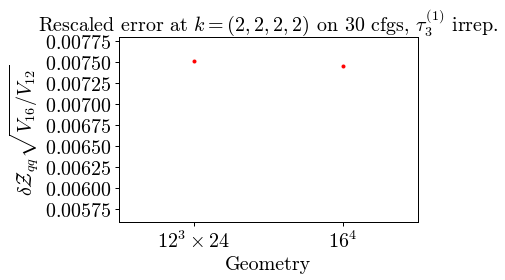

In [41]:
asp_ratio = 4/3
fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
plt.figure()
plt.scatter([0, 1], dat1_stds_rescale, marker = '.', color = 'r')
ax = plt.gca()
ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['$12^3\\times 24$', '$16^4$'])
for spine in spinedirs:
    ax.spines[spine].set_linewidth(style['axeswidth'])
plt.xticks(fontsize = style['fontsize'])
plt.yticks(fontsize = style['fontsize'])
plt.xlabel('Geometry', fontsize = style['fontsize'])
plt.ylabel('$\delta\mathcal{Z}_{qq} \sqrt{V_{16} / V_{12}}$', fontsize = style['fontsize'])
plt.xlim((-0.5, 1.5))
plt.ylim((0.0056, 0.0078))
plt.title('Rescaled error at $k = (2, 2, 2, 2)$ on 30 cfgs, $\\tau^{(1)}_3$ irrep.', fontsize = style['fontsize'])
plt.tight_layout()
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/error_scaling/fixed_k_error_rescaled.pdf', bbox_inches='tight')
plt.show()

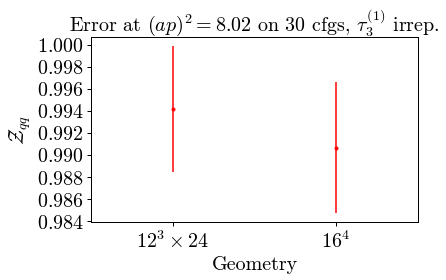

In [42]:
asp_ratio = 4/3
fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
plt.figure()
plt.errorbar([0, 1], dat2_cvs, dat2_stds, fmt = '.', c = 'r')
ax = plt.gca()
ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['$12^3\\times 24$', '$16^4$'])
for spine in spinedirs:
    ax.spines[spine].set_linewidth(style['axeswidth'])
plt.xticks(fontsize = style['fontsize'])
plt.yticks(fontsize = style['fontsize'])
plt.xlabel('Geometry', fontsize = style['fontsize'])
plt.ylabel('$\mathcal{Z}_{qq}$', fontsize = style['fontsize'])
plt.xlim((-0.5, 1.5))
plt.title('Error at $(ap)^2 = 8.02$ on 30 cfgs, $\\tau^{(1)}_3$ irrep.', fontsize = style['fontsize'])
plt.tight_layout()
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/error_scaling/fixed_apsq_data.pdf', bbox_inches='tight')
plt.show()

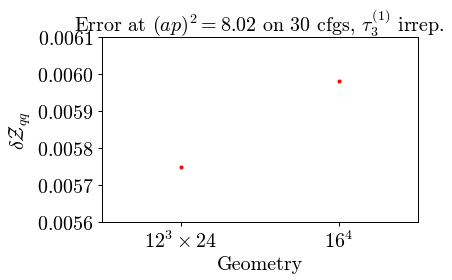

In [43]:
asp_ratio = 4/3
fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
plt.figure()
plt.scatter([0, 1], dat2_stds, marker = '.', color = 'r')
ax = plt.gca()
ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['$12^3\\times 24$', '$16^4$'])
for spine in spinedirs:
    ax.spines[spine].set_linewidth(style['axeswidth'])
plt.xticks(fontsize = style['fontsize'])
plt.yticks(fontsize = style['fontsize'])
plt.xlabel('Geometry', fontsize = style['fontsize'])
plt.ylabel('$\delta\mathcal{Z}_{qq}$', fontsize = style['fontsize'])
plt.xlim((-0.5, 1.5))
plt.ylim((0.0056, 0.0061))
plt.title('Error at $(ap)^2 = 8.02$ on 30 cfgs, $\\tau^{(1)}_3$ irrep.', fontsize = style['fontsize'])
plt.tight_layout()
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/error_scaling/fixed_apsq_error.pdf', bbox_inches='tight')
plt.show()

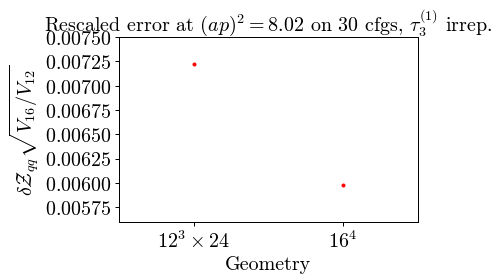

In [44]:
asp_ratio = 4/3
fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
plt.figure()
plt.scatter([0, 1], dat2_stds_rescale, marker = '.', color = 'r')
ax = plt.gca()
ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['$12^3\\times 24$', '$16^4$'])
for spine in spinedirs:
    ax.spines[spine].set_linewidth(style['axeswidth'])
plt.xticks(fontsize = style['fontsize'])
plt.yticks(fontsize = style['fontsize'])
plt.xlabel('Geometry', fontsize = style['fontsize'])
plt.ylabel('$\delta\mathcal{Z}_{qq} \sqrt{V_{16} / V_{12}}$', fontsize = style['fontsize'])
plt.xlim((-0.5, 1.5))
# plt.ylim((0.0056, 0.0061))
plt.ylim((0.0056, 0.0075))
plt.title('Rescaled error at $(ap)^2 = 8.02$ on 30 cfgs, $\\tau^{(1)}_3$ irrep.', fontsize = style['fontsize'])
plt.tight_layout()
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/error_scaling/fixed_apsq_error_rescaled.pdf', bbox_inches='tight')
plt.show()

# Convert to $\overline{\mathrm{MS}}$

We'll do most of this in Mathematica. Note that given the anomalous dimension $\gamma_{qq}$, we have the RGE:
$$
    \frac{\mu}{Z}\frac{dZ}{d\mu} = -\gamma_{qq}(\alpha_s(\mu))\implies \int_{Z(\mu)}^{Z(\mu_0)} \frac{dZ}{Z} = \int_{\mu}^{\mu_0} \frac{d\mu'}{\mu'}\gamma_{qq}(\alpha_s(\mu'))
$$
where $\mu$ is the non-perturbative scale and $\mu_0 = 2 \;\mathrm{GeV}$ is the matching scale. Hence:
$$
    Z(\mu_0) = Z(\mu) \exp\left( -\int_\mu^{\mu_0} \frac{d\mu'}{\mu'}\gamma_{qq}(\alpha_s(\mu')) \right)
$$
So, for each non-perturbative mode we will compute this anomalous dimension integral. 

#### Run to $\mu_0 = 2\;\mathrm{GeV}$

In [45]:
runpath = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/scheme_running/rimom_Zqq_48_96.h5'
frun = h5py.File(runpath, 'r')
run_moms = frun['momenta'][()]
run_ratios = frun['ratios'][()]
RQQ = frun['RQQ'][()]
RQG = frun['RQG'][()]
frun.close()
assert np.all(run_moms == k_list48), 'Wrong momenta run in frun'

In [46]:
h_list48 = np.array([h(k) for k in k_list48])

In [48]:
# Zqq_48_mu0 = np.einsum('tpb,p->tpb', Zqq_mix_48, run_ratios)
# 1. Match
# RQQ_Zqq_MSbar_muR_48 = np.einsum('tpb,p->tpb', 1/Zqq_mix_48, RQQ)
RQQ_Zqq_MSbar_48 = np.einsum('tpb,p->tpb', 1/Zqq_mix_48, RQQ)
RQG_Zqq_MSbar_48 = np.einsum('tpb,p->tpb', 1/Zqq_mix_48, RQG)
# 2. Run
# RQQ_Zqq_MSbar = np.einsum('tpb,p->tpb', RQQ_Zqq_MSbar_muR_48, run_ratios)
# RQG_Zqq_MSbar = np.einsum('tpb,p->tpb', RQG_Zqq_MSbar_muR_48, run_ratios)

RQQ_Zqq_48_mu = np.mean(np.real(RQQ_Zqq_MSbar_48), axis = 2)
RQQ_Zqq_48_sigma = np.std(np.real(RQQ_Zqq_MSbar_48), axis = 2, ddof = 1)
RQG_Zqq_48_mu = np.mean(np.real(RQG_Zqq_MSbar_48), axis = 2)
RQG_Zqq_48_sigma = np.std(np.real(RQG_Zqq_MSbar_48), axis = 2, ddof = 1)

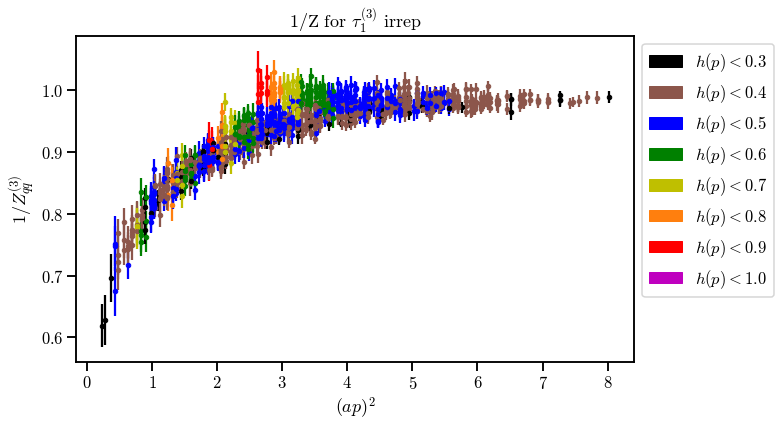

In [49]:
Zqq_inv_mix_48_mu = np.mean(np.real(1/Zqq_mix_48), axis = 2)
Zqq_inv_mix_48_sigma = np.std(np.real(1/Zqq_mix_48), axis = 2, ddof = 1)
plot_h4_breaking(apsq_list48, Zqq_inv_mix_48_mu[0], Zqq_inv_mix_48_sigma[0], '$1/Z_{qq}^{(3)}$', color_list48, \
                 title = '1/Z for $\\tau_1^{(3)}$ irrep')

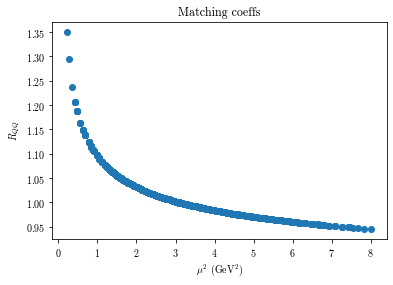

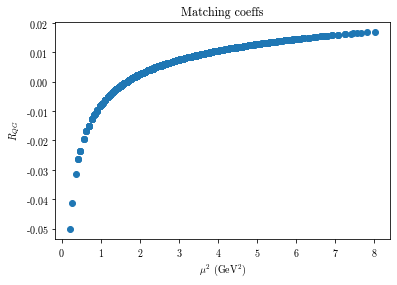

In [50]:
plt.figure()
plt.scatter(apsq_list48, RQQ)
plt.title('Matching coeffs')
plt.xlabel('$\mu^2$ (GeV$^2$)')
plt.ylabel('$R_{QQ}$')
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/RQQ.pdf')
plt.show()
plt.figure()
plt.scatter(apsq_list48, RQG)
plt.title('Matching coeffs')
plt.xlabel('$\mu^2$ (GeV$^2$)')
plt.ylabel('$R_{QG}$')
plt.savefig('/Users/theoares/Dropbox (MIT)/research/gq_mixing/plots/RQG.pdf')
plt.show()

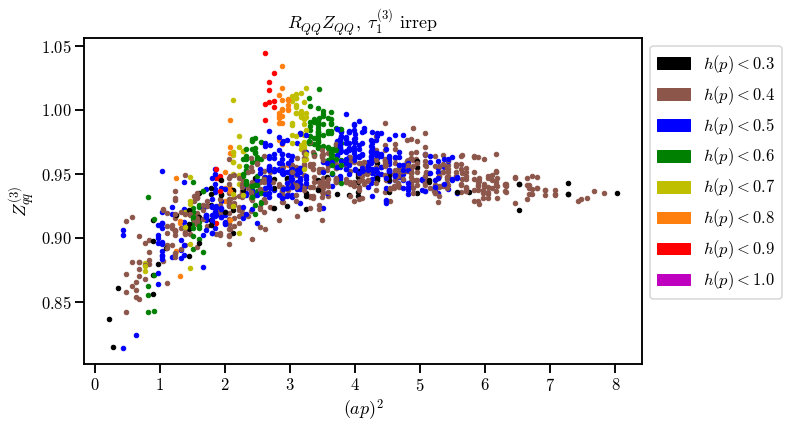

In [51]:
plot_h4_breaking(apsq_list48, RQQ_Zqq_48_mu[0], RQG_Zqq_48_sigma[0], '$Z_{qq}^{(3)}$', color_list48, \
                 title = '$R_{QQ} Z_{QQ},\;\\tau_1^{(3)}$ irrep')

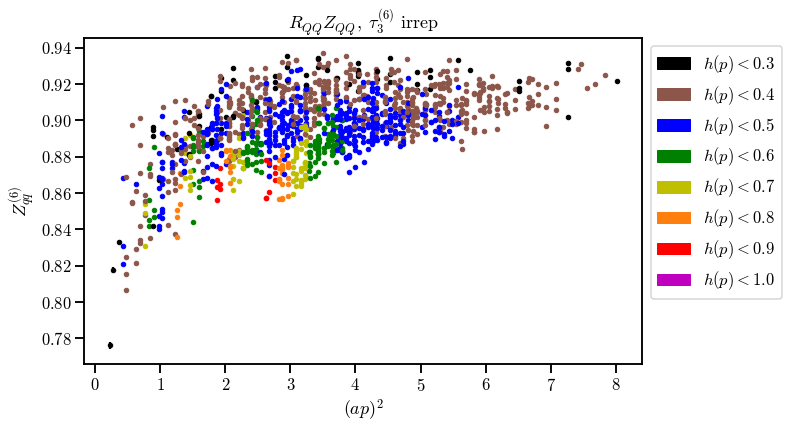

In [52]:
plot_h4_breaking(apsq_list48, RQQ_Zqq_48_mu[1], RQG_Zqq_48_sigma[1], '$Z_{qq}^{(6)}$', color_list48, \
                 title = '$R_{QQ} Z_{QQ},\;\\tau_3^{(6)}$ irrep')

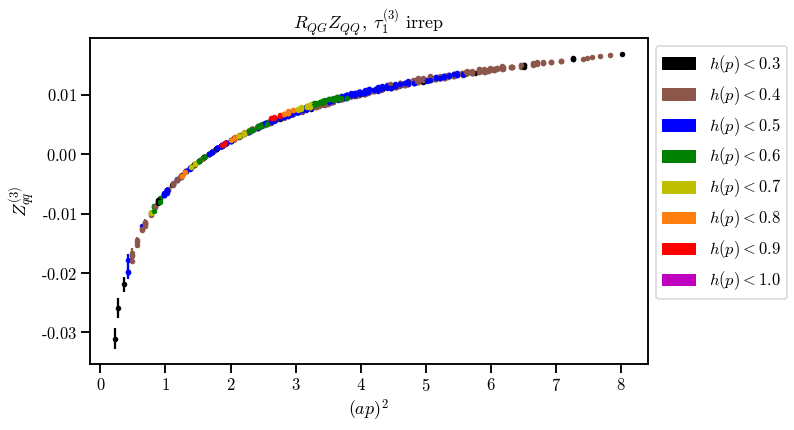

In [53]:
plot_h4_breaking(apsq_list48, RQG_Zqq_48_mu[0], RQG_Zqq_48_sigma[0], '$Z_{qq}^{(3)}$', color_list48, \
                 title = '$R_{QG} Z_{QQ},\;\\tau_1^{(3)}$ irrep')

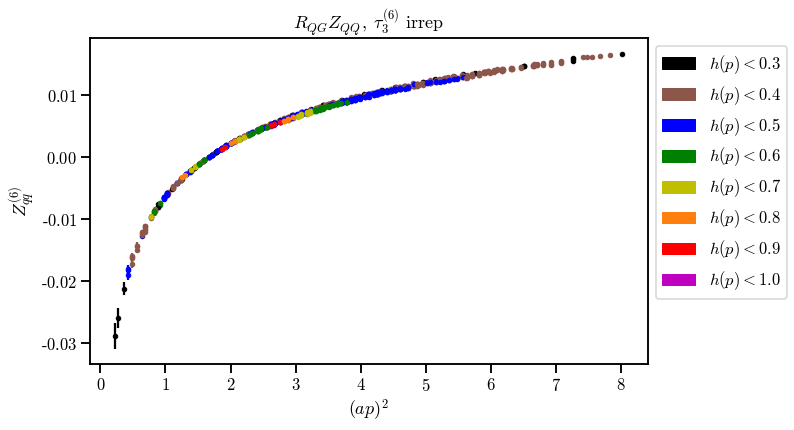

In [54]:
plot_h4_breaking(apsq_list48, RQG_Zqq_48_mu[1], RQG_Zqq_48_sigma[1], '$Z_{qq}^{(6)}$', color_list48, \
                 title = '$R_{QG} Z_{QQ},\;\\tau_3^{(6)}$ irrep')

In [57]:
outpath = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/ZMSbar_115282.h5'
fout = h5py.File(outpath, 'w')
fout['momenta'] = k_list48
fout['RqqZqq'] = RQQ_Zqq_MSbar_48
fout['RqgZqq'] = RQG_Zqq_MSbar_48
fout.close()
print('Output saved to ' + outpath)

Output saved to /Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/ZMSbar_115282.h5
